## Synthesis of a Sentiment Analysis Model for Investigating Amazon Product Reviews and Customer Segmentation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings            
warnings.filterwarnings("ignore")
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
Amazon_review = pd.read_csv('Amazon_Reviews.tsv', sep='\t', error_bad_lines=False)

Skipping line 9076: expected 15 fields, saw 22
Skipping line 19256: expected 15 fields, saw 22
Skipping line 24313: expected 15 fields, saw 22
Skipping line 47211: expected 15 fields, saw 22
Skipping line 54295: expected 15 fields, saw 22
Skipping line 56641: expected 15 fields, saw 22
Skipping line 63067: expected 15 fields, saw 22

Skipping line 93796: expected 15 fields, saw 22

Skipping line 132806: expected 15 fields, saw 22
Skipping line 164631: expected 15 fields, saw 22
Skipping line 167019: expected 15 fields, saw 22
Skipping line 167212: expected 15 fields, saw 22

Skipping line 198103: expected 15 fields, saw 22
Skipping line 199191: expected 15 fields, saw 22
Skipping line 202841: expected 15 fields, saw 22
Skipping line 218228: expected 15 fields, saw 22
Skipping line 235900: expected 15 fields, saw 22

Skipping line 277761: expected 15 fields, saw 22
Skipping line 304582: expected 15 fields, saw 22
Skipping line 312029: expected 15 fields, saw 22

Skipping line 343692: ex

# Data Preprocessing and Cleaning

In [3]:
Amazon_review.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5.0,0.0,0.0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5.0,0.0,0.0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5.0,1.0,1.0,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1.0,0.0,0.0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5.0,1.0,1.0,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [4]:
Amazon_review.shape

(750825, 15)

In [5]:
Amazon_review.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [6]:
Amazon_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750825 entries, 0 to 750824
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketplace        750825 non-null  object 
 1   customer_id        750825 non-null  int64  
 2   review_id          750825 non-null  object 
 3   product_id         750825 non-null  object 
 4   product_parent     750825 non-null  int64  
 5   product_title      750825 non-null  object 
 6   product_category   750825 non-null  object 
 7   star_rating        750824 non-null  float64
 8   helpful_votes      750824 non-null  float64
 9   total_votes        750824 non-null  float64
 10  vine               750824 non-null  object 
 11  verified_purchase  750824 non-null  object 
 12  review_headline    750821 non-null  object 
 13  review_body        750756 non-null  object 
 14  review_date        750822 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 8

In [7]:
Amazon_review.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           1
helpful_votes         1
total_votes           1
vine                  1
verified_purchase     1
review_headline       4
review_body          69
review_date           3
dtype: int64

In [8]:
Amazon_review.dropna(inplace=True)

# Exploratory Data Analysis

In [9]:
Amazon_review.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,7.507510e+05,7.507510e+05,750751.000000,750751.000000,750751.000000
mean,2.560921e+07,5.086416e+08,4.104349,0.688736,0.932565
std,1.622459e+07,2.886770e+08,1.374749,8.705627,9.418573
min,1.000500e+04,6.478000e+03,1.000000,0.000000,0.000000
25%,1.235933e+07,2.564213e+08,4.000000,0.000000,0.000000
50%,2.370449e+07,5.057122e+08,5.000000,0.000000,0.000000
75%,4.094785e+07,7.634480e+08,5.000000,0.000000,1.000000
max,5.309658e+07,9.999911e+08,5.000000,3287.000000,3369.000000


In [10]:
Amazon_review['star_rating'].value_counts()

5.0    461594
4.0    113056
1.0     83945
3.0     52893
2.0     39263
Name: star_rating, dtype: int64

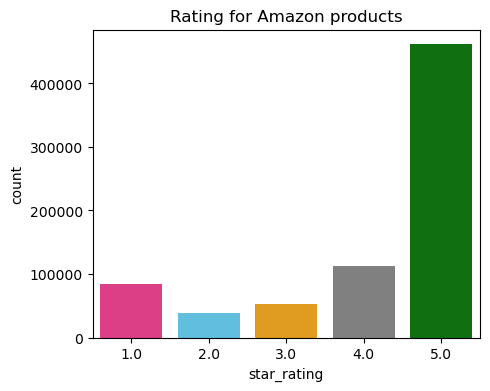

In [11]:
plt.figure(figsize=(5,4))
plt.title('Rating for Amazon products')
ax = sns.countplot(x='star_rating', data=Amazon_review, palette=['#F72585', '#4CC9F0','orange',"grey",'green'])
plt.show()

In [12]:
Amazon_review['sentiment'] = np.where(Amazon_review['star_rating'] >= 4, 'Positive', 'Negative')
Amazon_review.reset_index(drop=True, inplace=True)

In [13]:
Amazon_review['review_date'] = pd.to_datetime(Amazon_review['review_date'])

In [14]:
Amazon_review.set_index('review_date', inplace=True)

In [15]:
monthly_avg_rating = Amazon_review['star_rating'].resample('M').mean()

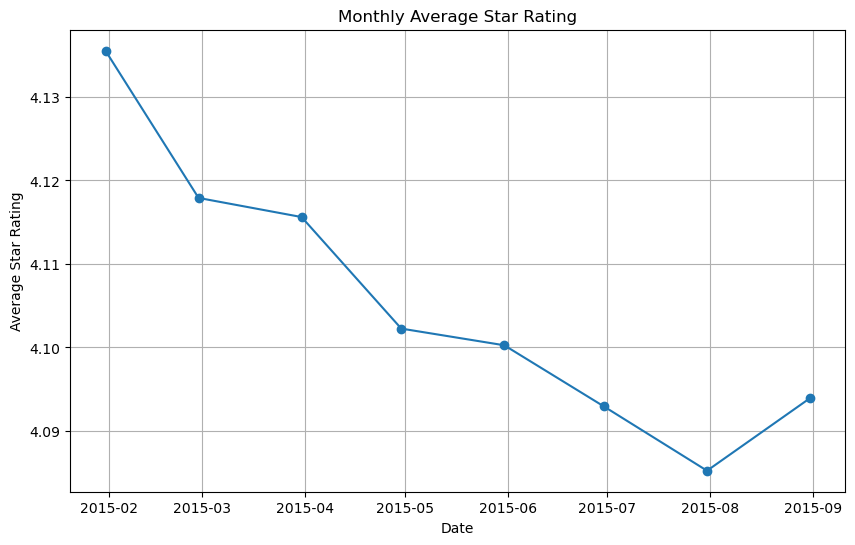

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_rating.index, monthly_avg_rating.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.title('Monthly Average Star Rating')
plt.grid(True)
plt.show()

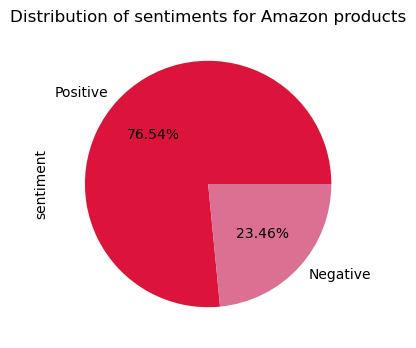

In [17]:
sentiments=Amazon_review['sentiment'].value_counts()
plt.figure(figsize=(4,4))
sentiments.plot(kind='pie', colors=['crimson','palevioletred'], autopct='%1.2f%%')
plt.title('Distribution of sentiments for Amazon products')
plt.show()

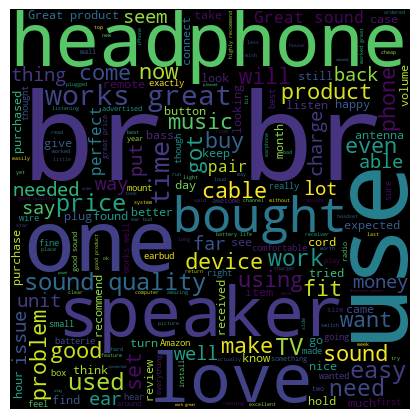

In [18]:
#quick overview of the most common words used in the dataset
wordcloud = WordCloud(width=400, height=400, background_color='black').generate(' '.join(Amazon_review['review_body']))
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
Amazon_review.reset_index(drop=True, inplace=True)

In [20]:
def clean_reviews(reviews):
    reviews = reviews.lower()                      #converts text to lowercase making it case-insensitive
    reviews = re.sub('\[.*?\]', '', reviews)       #removes text enclosed within square brackets 
    reviews = re.sub('https?://\S+|www\.\S+', '', reviews)       #removes URLs and web links from the text
    reviews = re.sub('<.*?>+', '', reviews)                      #removes HTML tags from text
    reviews = re.sub('[%s]' % re.escape(string.punctuation), '', reviews)      #removes punctuation characters
    reviews = re.sub('\n', '', reviews)            #removes newline characters
    reviews = re.sub('\w*\d\w*', '', reviews)      # removes words that contain digits that is alphanumeric words from the text
    return reviews

In [21]:
Amazon_review['review_body'] = Amazon_review['review_body'].apply(lambda x: clean_reviews(x))

In [22]:
def emoji_remove(reviews):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', reviews)

In [23]:
Amazon_review['review_body'] = Amazon_review['review_body'].apply(lambda x: emoji_remove(x))

In [24]:
Amazon_review['review_body'].apply(lambda x:len(str(x).split())).max()

7047

In [25]:
review_bodylength = pd.Series([len(review_body.split()) for review_body in Amazon_review['review_body']])

Text(0, 0.5, 'Frequency')

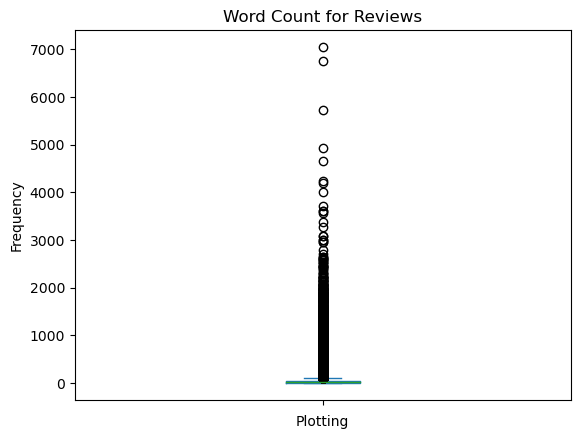

In [26]:
review_bodylength.plot(kind='box')
plt.title('Word Count for Reviews')
plt.xlabel('Plotting')
plt.ylabel('Frequency')

# Split the Amazon Review in Train Data and Test Data

In [27]:
review_data=Amazon_review[['review_body','sentiment']]

In [28]:
train_data,test_data = train_test_split(review_data,test_size = 0.20,random_state=121,stratify = review_data.sentiment)
print("train data shape : ", train_data.shape)
print("test data shape : ", test_data.shape)

train data shape :  (600600, 2)
test data shape :  (150151, 2)


In [29]:
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace', stop_words = stop)

In [30]:
X_train = vectorizer.fit_transform(train_data.review_body.values)
X_test = vectorizer.transform(test_data.review_body.values)

In [31]:
y_train = train_data.sentiment.values
y_test = test_data.sentiment.values

# Naive Bayes

In [32]:
NaiveBayes = MultinomialNB()
NaiveBayes.fit(X_train,y_train)

MultinomialNB()

In [33]:
NaiveBayes_prediction = NaiveBayes.predict(X_test)

In [34]:
NaiveBayes_accuracy = accuracy_score(y_test,NaiveBayes_prediction)*100
print(" accuracy Score :",NaiveBayes_accuracy)

 accuracy Score : 87.89019054152153


In [35]:
print(classification_report(NaiveBayes_prediction,y_test))

              precision    recall  f1-score   support

    Negative       0.63      0.81      0.71     27497
    Positive       0.95      0.89      0.92    122654

    accuracy                           0.88    150151
   macro avg       0.79      0.85      0.82    150151
weighted avg       0.90      0.88      0.88    150151



In [36]:
#evaluating perfomance of classification model
print(confusion_matrix(NaiveBayes_prediction,y_test))

[[ 22267   5230]
 [ 12953 109701]]


# Gradient Boosting Classifier

In [37]:
gb_amz=GradientBoostingClassifier()

In [38]:
gb_amz=gb_amz.fit(X_train,y_train)

In [39]:
gb_amz_predict=gb_amz.predict(X_test)

In [40]:
gb_amz_score=accuracy_score(y_test,gb_amz_predict)*100

In [41]:
gb_amz_score

83.25951875112388

In [42]:
print(classification_report(y_test,gb_amz_predict))

              precision    recall  f1-score   support

    Negative       0.86      0.34      0.49     35220
    Positive       0.83      0.98      0.90    114931

    accuracy                           0.83    150151
   macro avg       0.84      0.66      0.70    150151
weighted avg       0.84      0.83      0.80    150151



In [43]:
#evaluating perfomance of classification model
confusion_matrix(y_test,gb_amz_predict)

array([[ 12084,  23136],
       [  2000, 112931]], dtype=int64)

## Logistic Regression

In [44]:
lr_amz=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

In [45]:
lr_amz=lr_amz.fit(X_train,y_train)

In [46]:
lr_amz_predict=lr_amz.predict(X_test)

In [47]:
lr_amz_score=accuracy_score(y_test,lr_amz_predict)*100

In [48]:
lr_amz_score

89.21752102883099

In [49]:
print(classification_report(y_test,lr_amz_predict))

              precision    recall  f1-score   support

    Negative       0.82      0.69      0.75     35220
    Positive       0.91      0.96      0.93    114931

    accuracy                           0.89    150151
   macro avg       0.87      0.82      0.84    150151
weighted avg       0.89      0.89      0.89    150151



In [50]:
#evaluating perfomance of classification model
confusion_matrix(y_test,lr_amz_predict)

array([[ 24172,  11048],
       [  5142, 109789]], dtype=int64)

# SGD Classifier

In [51]:
sgd_amz=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

In [52]:
sgd_amz=sgd_amz.fit(X_train,y_train)

In [53]:
sgd_amz_predict=sgd_amz.predict(X_test)

In [54]:
sgd_amz_score=accuracy_score(y_test,sgd_amz_predict)*100

In [55]:
sgd_amz_score

89.21752102883099

In [56]:
print(classification_report(y_test,sgd_amz_predict))

              precision    recall  f1-score   support

    Negative       0.82      0.69      0.75     35220
    Positive       0.91      0.96      0.93    114931

    accuracy                           0.89    150151
   macro avg       0.87      0.82      0.84    150151
weighted avg       0.89      0.89      0.89    150151



In [57]:
#evaluating perfomance of classification model
confusion_matrix(y_test,sgd_amz_predict)

array([[ 24172,  11048],
       [  5142, 109789]], dtype=int64)

## Comparision of the Model

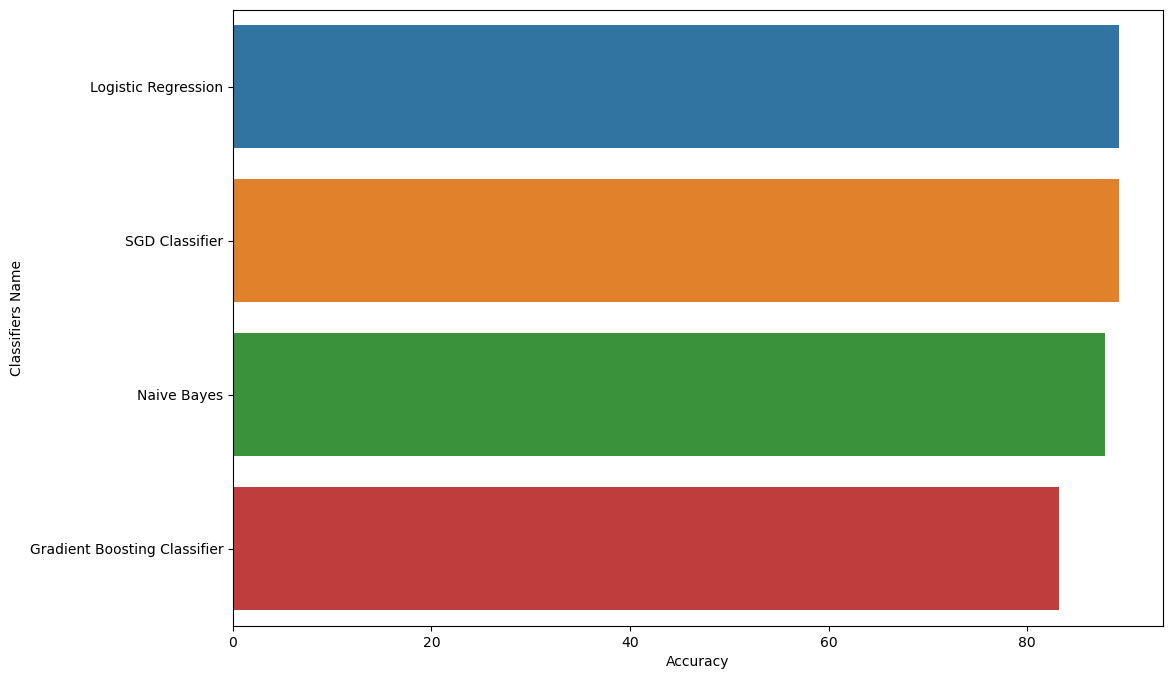

In [58]:
data = [['Logistic Regression', lr_amz_score],['Naive Bayes', NaiveBayes_accuracy],
       ['Gradient Boosting Classifier', gb_amz_score],['SGD Classifier', sgd_amz_score]]
df = pd.DataFrame(data, columns=['Classifiers Name', 'Accuracy'])
df = df.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='Accuracy', y='Classifiers Name', data = df)
plt.show()